In [1]:
import matplotlib.pyplot as plt
from pylab import imshow, figure, plot, colorbar, show, hist
%matplotlib inline

In [4]:
import data
import numpy as np

## Number of cancer and benign nodules, train/test split

In [5]:
df_nodes = data.ndsb17_get_df_nodes() 
df_nodes = df_nodes[(df_nodes["diameter_mm"]>=9)]

X_cancer_nodules, cancer_diams = data.ndsb17_get_all_nodules(np.asarray([64,64,64]), df_nodes)
print("cancer nodules", len(X_cancer_nodules))

df_benign = data.ndsb17_get_df_nodes(cancer_label=0)
X_benign_nodules, benign_diams = data.ndsb17_get_all_nodules(np.asarray([64,64,64]), df_benign)
print("benign nodules", len(X_benign_nodules))

b8dc33b670bb078d10954345c3ffbb3a FileNotFoundError(2, 'No such file or directory')
cancer nodules 324
benign nodules 180


In [6]:
fold = 0
X_cancer_nodules_train, X_cancer_nodules_test = data.kfold_split(X_cancer_nodules, fold)
X_benign_nodules_train, X_benign_nodules_test = data.kfold_split_fixed(X_benign_nodules, fold, size=len(X_cancer_nodules_test))
print(len(X_cancer_nodules_train), len(X_cancer_nodules_test))
print(len(X_benign_nodules_train), len(X_benign_nodules_test))

259 64
143 36


In [11]:
test_nodules = np.stack(X_benign_nodules_test + X_cancer_nodules_test)[:,16:16+32,16:16+32,16:16+32,None]
test_nodules = datagen.preprocess(test_nodules)
if config.do_downscale:
    test_nodules = skimage.transform.downscale_local_mean(test_nodules, (1,2,2,2,1), clip=False)
test_y = np.concatenate( (np.zeros((len(X_benign_nodules_test),)), np.ones((len(X_cancer_nodules_test),))) )


In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [9]:
import datagen
import net
import importlib
config_name = 'config_baseline4_classifier'
localizer_weights_file = ''
config = importlib.import_module(config_name)


In [10]:
model = net.model3d(config.net_input_vsize, sz=config.feature_sz, alpha=config.feature_alpha)
# model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=get_optimizer(config.lr))
model.load_weights('/mnt/data/snap/classifier_paper.h5', by_name=True)


In [12]:
pred_y = model.predict(test_nodules)
print(pred_y.shape)




(100, 1)


NameError: name 'sklearn' is not defined

In [13]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_y, pred_y)
auc = sklearn.metrics.auc(fpr, tpr)
print("auc", auc)

auc 0.892361111111


## ROC AUC

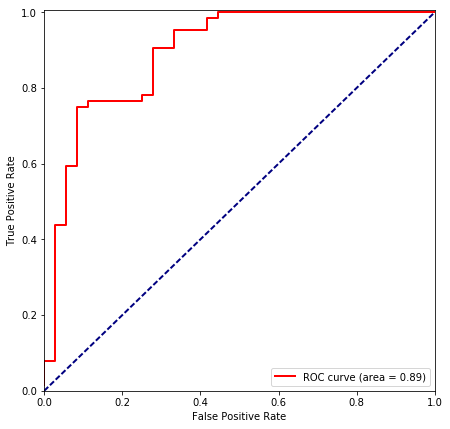

In [22]:
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [35]:
import matplotlib.gridspec as gridspec

def image_grid(images, num_rows=4, num_cols=4, figsize=(10,10)):
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.1)

    ax = [plt.subplot(gs[i]) for i in range(num_rows*num_cols)]
    gs.update(hspace=0)
    
    for i,im in enumerate(images):
        ax[i].imshow(im, vmin=-1100, vmax=200, cmap='gray')
        ax[i].axis('off')
    plt.show()

## Random examples of nodules

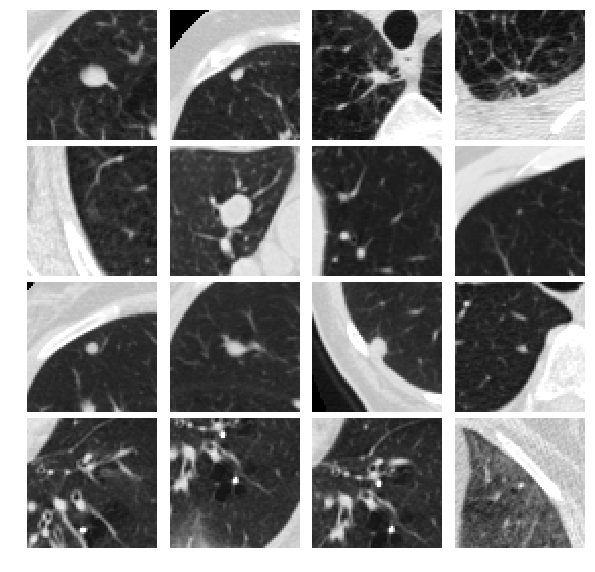

In [42]:
image_grid([ x[32] for x in X_benign_nodules_test[20:36][::-1] ])

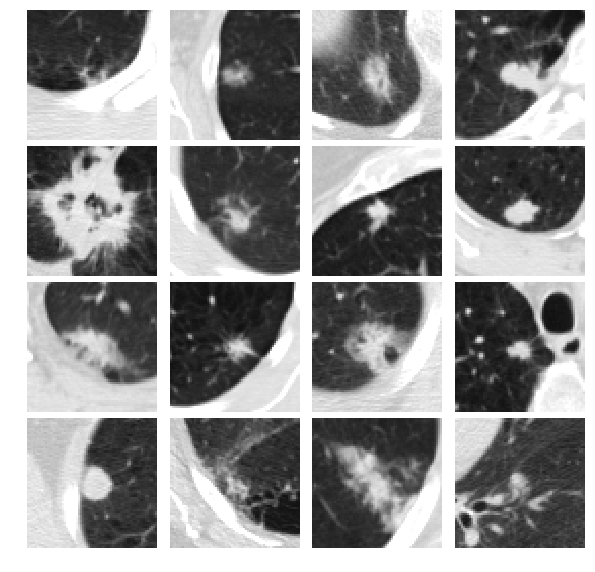

In [37]:
image_grid([ x[32] for x in X_cancer_nodules_test[:16] ])

In [62]:
idxs = np.argsort(pred_y[:,0])

In [63]:
test_nodules_big = np.stack(X_benign_nodules_test + X_cancer_nodules_test)

## Misclassified: cancer as benign

p = 0.12722


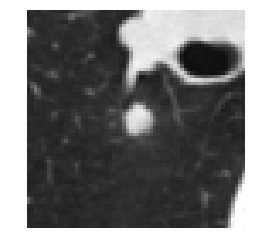

p = 0.236631


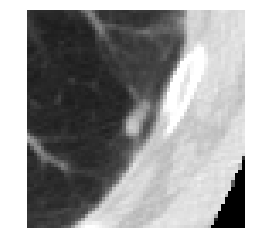

p = 0.257036


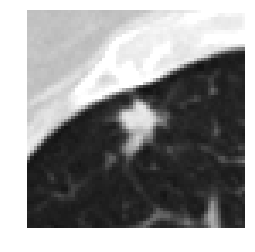

p = 0.497835


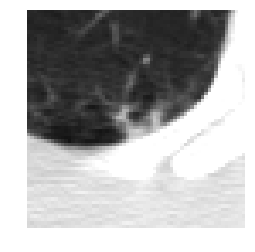

In [67]:
n = 0
for i in idxs:
    if test_y[i] == 1 and pred_y[i,0] < 0.5:
        print("p = " + str(pred_y[i,0]))
        imshow(test_nodules_big[i, 32], vmin=-1100, vmax=200, cmap='gray')
        plt.axis('off')
        plt.show()
        n += 1
        if n > 5:
            break

## Misclassified: benign as cancer

p = 0.996884


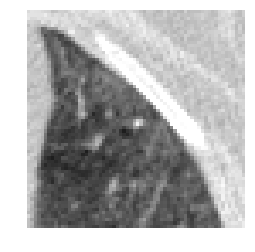

p = 0.948195


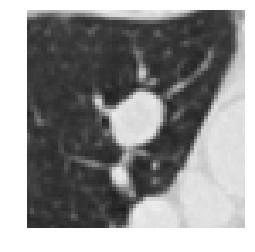

p = 0.933127


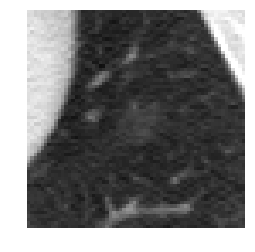

p = 0.9077


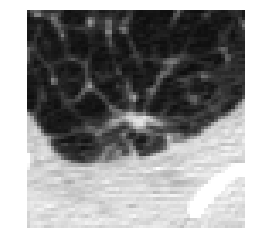

p = 0.896179


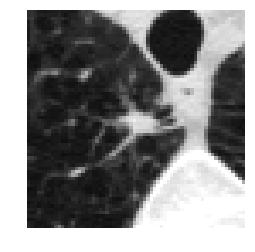

p = 0.893935


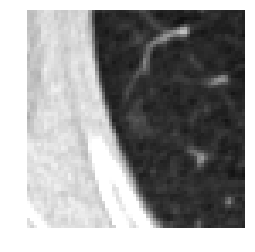

In [68]:
n = 0
for i in idxs[::-1]:
    if test_y[i] == 0 and pred_y[i,0] > 0.5:
        print("p = " + str(pred_y[i,0]))
        imshow(test_nodules_big[i, 32], vmin=-1100, vmax=200, cmap='gray')
        plt.axis('off')
        plt.show()
        n += 1
        if n > 5:
            break